# PDB structure analysis

## List of software used in the work

The work was performed in JupyterLab 4.0.6; on the Linux operating system Ubuntu 22.04.3 LTS. List of software used in the work:

|Название|Версия|
|--|--|
|NumPy|1.26.0|
|Seaborn|0.13.0|
|SciPy|1.11.3|
|nglview|3.0.8|
|MDAnalysis|2.6.1|
|ProDy|2.4.0|
|pdb2pqr|3.6.1|
|propka|3.5.0|
|reduce|3.24|
|UCSF Chimera|1.17.3|

Choose and load a PBD structure and perform the steps below:

1. Add hydrogens to the PDB structure.
2. Determine hydrogen bonds.
3. Construct Ramachandran plot.
4. Build contact map.
5. Determine the protonation state of ionized amino acid residues.
6. Define electrostatic surface.
7. Performe dynamics analysis using anisotropic network model (ANM).

## Load all packages

In [100]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.spatial.distance import pdist,squareform

import nglview as nv
import MDAnalysis
from MDAnalysis.analysis.dihedrals import Dihedral
from MDAnalysis.analysis.dihedrals import Ramachandran
import prody

## Load and visualize a PDB structure

In this work I used the PDB structure: [**5LF2**](https://www.rcsb.org/structure/5LF2) (laminin beta2 LE5-LF-LE6)

Laminins are glycoproteins that are one of the most important components of the base membrane and are involved in cell adhesion.

Downloaded the PDB structure.

In [103]:
struct_id = '5LF2'

In [104]:
!wget https://files.rcsb.org/view/{struct_id}.pdb

--2023-10-22 20:50:32--  https://files.rcsb.org/view/5LF2.pdb
Распознаётся files.rcsb.org (files.rcsb.org)… 128.6.159.157, 132.249.213.193, 132.249.213.241, ...
Подключение к files.rcsb.org (files.rcsb.org)|128.6.159.157|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [text/plain]
Сохранение в: ‘5LF2.pdb’

5LF2.pdb                [      <=>           ]   1,16M  97,1KB/s    за 11s     

2023-10-22 20:50:45 (106 KB/s) - ‘5LF2.pdb’ сохранён [1219293]



Explored its content.

In [105]:
!head {struct_id}.pdb

HEADER    CELL ADHESION                           30-JUN-16   5LF2              
TITLE     CRYSTAL STRUCTURE OF LAMININ BETA2 LE5-LF-LE6                         
COMPND    MOL_ID: 1;                                                            
COMPND   2 MOLECULE: LAMININ SUBUNIT BETA-2;                                    
COMPND   3 CHAIN: A, B;                                                         
COMPND   4 FRAGMENT: UNP RESIDUES 523-833;                                      
COMPND   5 SYNONYM: LAMININ CHAIN B3,LAMININ-11 SUBUNIT BETA,LAMININ-14 SUBUNIT 
COMPND   6 BETA,LAMININ-15 SUBUNIT BETA,LAMININ-3 SUBUNIT BETA,LAMININ-4 SUBUNIT
COMPND   7 BETA,LAMININ-7 SUBUNIT BETA,LAMININ-9 SUBUNIT BETA,S-LAMININ SUBUNIT 
COMPND   8 BETA,S-LAM BETA;                                                     


Viewed the structure.

In [106]:
view = nv.show_structure_file(f'{struct_id}.pdb')
view

NGLWidget()

## 1. Addition of hydrogens to structure

Using the `reduce` utility, I added hydrogens and saved them to a separate file.

In [107]:
!reduce {struct_id}.pdb > {struct_id}_reduce.pdb

reduce: version 3.24 07/24/2013, Copyright 1997-2013, J. Michael Word
Processing file: "5LF2.pdb"
Database of HETATM connections: "/home/snitkin/anaconda3/envs/molmodel/share/reduce/reduce_wwPDB_het_dict.txt"
VDW dot density = 16/A^2
Orientation penalty scale = 1 (100%)
Eliminate contacts within 3 bonds.
Ignore atoms with |occupancy| <= 0.01 during adjustments.
Waters ignored if B-Factor >= 40 or |occupancy| < 0.66
Aromatic rings in amino acids accept hydrogen bonds.
Building or keeping OH & SH Hydrogens.
Rotating NH3 Hydrogens.
Processing Met methyls.
*WARNING*: Residues ARG 704  and SER 714  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 704  and SER 714  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 704  and GLY 713  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 704  and GLY 713  in chain  B appear unbonded 
          

Hydrogens have been added with the label `new`.

In [117]:
!grep "\snew$" {struct_id}_reduce.pdb

ATOM      0  H   ARG A 545      26.810  66.597  69.528  1.00 51.79           H   new
ATOM      0  H   ARG B 545      63.031  20.529   5.762  1.00 49.11           H   new


## 2. Determination of hydrogen bonds

Загрузил PDB структуру в UCSF Chimera. Изобразил в виде палочек и шариков: `Actions > Atoms/Bonds > ball & stick`. Зашёл в меню: `Tools > Structure Analysis > FindHBond`. Выбрал толщину водородных связей `Line width` равной 3.0. Нажал `Apply`, получил изображение с водородными связями:

Uploaded PDB structure to UCSF Chimera. Depicted in the form of balls and sticks: `Actions > Atoms/Bonds > ball & stick`. I went to the menu: `Tools > Structure Analysis > FindHBond`. I chose the thickness of hydrogen bonds `Line width` to be 3.0. Clicked `Apply` and got an image with hydrogen bonds:

![](fig.1.png)

## 3. Dihedral angles analysis

Constructed a Ramachandran plot showing the relationship between the dihedral angles $\phi$ and $\psi$. I indicated the typical arrangement of beta sheets and right- and left-handed alpha helices.

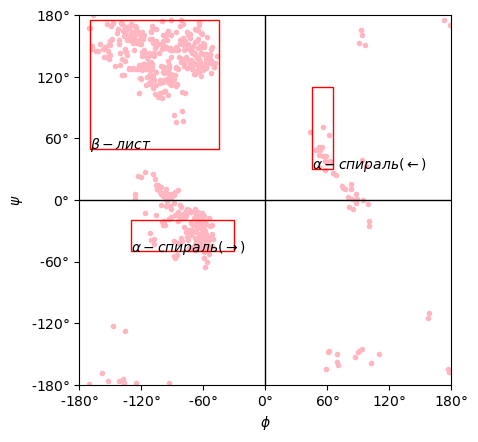

In [139]:
univ = MDAnalysis.Universe(f'{struct_id}.pdb')
select = univ.select_atoms('protein and name CA')
ramach = Ramachandran(select).run()

fig, ax = plt.subplots(figsize=plt.figaspect(1))
ramach.plot(ax=ax, color='lightpink', marker='.')
ax.add_patch (Rectangle((-170, 50), 125, 125,
    edgecolor='red',
    facecolor='none',
    lw= 1))
plt.text(-170, 50, "$\\beta-лист$")

ax.add_patch (Rectangle((-130, -50), 100, 30,
    edgecolor='red',
    facecolor='none',
    lw= 1))
plt.text(-130, -50, "$\\alpha-спираль(\\rightarrow$)")

ax.add_patch (Rectangle((45, 30), 20, 80,
    edgecolor='red',
    facecolor='none',
    lw= 1))
plt.text(45, 30, "$\\alpha-спираль(\\leftarrow$)")

plt.show()

## 4. Building contact map

I calculated the matrix of distances of all atoms with all and wrote it into the `dist_matrix` variable. Based on it, I built a contact map.

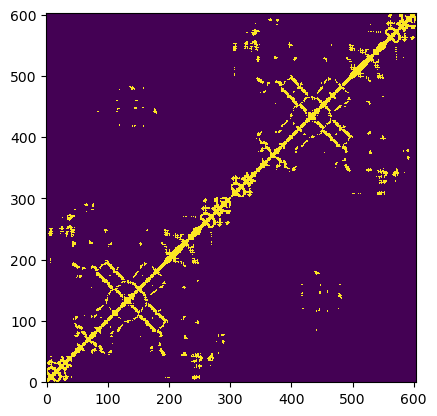

In [110]:
atoms_pos = select.atoms.positions
dist_matrix = squareform(pdist(atoms_pos))
plt.imshow(np.where(dist_matrix < 12, 1, 0),
           interpolation='nearest')
plt.gca().invert_yaxis()
plt.show()

## 5. Determination of the protonation state of ionized amino acid residues

Determined the protonation of amino acid residues in a protein using `propka3`.

In [111]:
!propka3 {struct_id}.pdb

Unexpected number (5) of atoms in residue ARG 523 A   in conformation 1A
Unexpected number (5) of atoms in residue ASP 526 A   in conformation 1A
Unexpected number (5) of atoms in residue GLN 536 A   in conformation 1A
Unexpected number (5) of atoms in residue ASP 538 A   in conformation 1A
Unexpected number (5) of atoms in residue GLU 539 A   in conformation 1A
Unexpected number (5) of atoms in residue ARG 545 A   in conformation 1A
Unexpected number (5) of atoms in residue HIS 578 A   in conformation 1A
Unexpected number (5) of atoms in residue VAL 581 A   in conformation 1A
Unexpected number (5) of atoms in residue ASN 591 A   in conformation 1A
Unexpected number (5) of atoms in residue ARG 592 A   in conformation 1A
Unexpected number (5) of atoms in residue GLU 593 A   in conformation 1A
Unexpected number (5) of atoms in residue GLU 766 A   in conformation 1A
Unexpected number (5) of atoms in residue ARG 545 B   in conformation 1A
Unexpected number (5) of atoms in residue ARG 592 B

I output the result to the console. The protonation state is determined by the dissociation constant, equal to the ratio of the product of the equilibrium concentrations of individual ions to the equilibrium concentration of the whole acid:

$pK_a=\frac{[A^-][H^+]}{[AH]}$

Each chemical group of amino acids has its own theoretical value $pK_a$, with which the calculated value is compared. If the calculated value is higher than the theoretical value, then that chemical group (for example, carboxyl) is more prone to deprotonation and vice versa.

In [112]:
!grep "SUMMARY OF THIS PREDICTION" {struct_id}.pka -A 10

SUMMARY OF THIS PREDICTION
       Group      pKa  model-pKa   ligand atom-type
   ASP 528 A     3.88       3.80                      
   ASP 534 A     4.01       3.80                      
   ASP 568 A     3.50       3.80                      
   ASP 623 A     4.81       3.80                      
   ASP 625 A     3.47       3.80                      
   ASP 664 A     3.85       3.80                      
   ASP 665 A     4.15       3.80                      
   ASP 719 A     6.11       3.80                      
   ASP 737 A     2.85       3.80                      


## 6. Definition of electrostatic surface

Used the programs `pdb2pqr` and `apbs` to create files with the extensions `.pqr` and `.dx` respectively.

In [113]:
!pdb2pqr --apbs-input {struct_id}_apbs.in --ff AMBER {struct_id}.pdb {struct_id}.pqr

INFO:PDB2PQR v3.6.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: 5LF2.pdb
INFO:Setting up molecule.
INFO:Created biomolecule object with 1043 residues and 9395 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 74 missing atoms in biomolecule.
INFO:Added atom CG to residue ARG A 523 at coordinates 42.074, 70.611, 77.243
INFO:Added atom CD to residue ARG A 523 at coordinates 42.912, 71.832, 77.141
INFO:Added atom NE to residue ARG A 523 at coordinates 43.607, 72.129, 78.38

In [114]:
!apbs {struct_id}_apbs.in



----------------------------------------------------------------------
    APBS -- Adaptive Poisson-Boltzmann Solver
    Version 1.5
    
    Nathan A. Baker (nathan.baker@pnnl.gov)
    Pacific Northwest National Laboratory
    
    Additional contributing authors listed in the code documentation.
    
    Copyright (c) 2010-2014 Battelle Memorial Institute. Developed at the Pacific
    Northwest National Laboratory, operated by Battelle Memorial Institute, Pacific
    Northwest Division for the U.S. Department of Energy.
    
    Portions Copyright (c) 2002-2010, Washington University in St. Louis.
    Portions Copyright (c) 2002-2010, Nathan A. Baker.
    Portions Copyright (c) 1999-2002, The Regents of the University of California.
    Portions Copyright (c) 1995, Michael Holst.
    All rights reserved.
    
    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are met:
    
    * Redistributio

Uploaded files with `.pqr` and `.dx` extensions to UCSF Chimera. In the **Model Panel** I included a model with the `.dx` extension and painted the surface based on it.

![](fig.2.png)

## 7. Dynamics analysis

Using `prody`, I parsed the PDB structure and wrote the resulting object `prody.atomic.atomgroup.AtomGroup` into the `prody_protein` variable.

@> 9395 atoms and 1 coordinate set(s) were parsed in 0.14s.


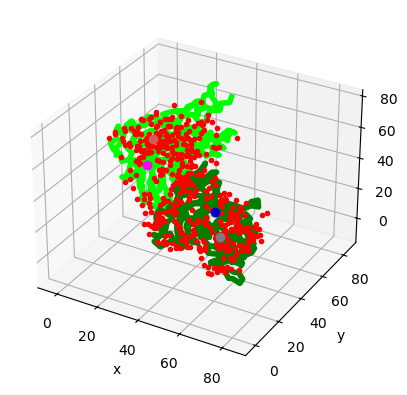

In [123]:
prody_protein = prody.parsePDB(f'{struct_id}.pdb')
_ = prody.showProtein(prody_protein)

In [120]:
type(prody_protein)

prody.atomic.atomgroup.AtomGroup

Based on the resulting object, I created an anisotropic network model (ANM). In simple words, this is a model in which all $C_\alpha$ atoms are represented as balls connected by springs.

In [125]:
protein = prody_protein.select('protein')
anm, atoms = prody.calcANM(protein, selstr='calpha')
slowest_mode = anm[0]
prody.writeNMD(f'{struct_id}.nmd', anm[:3], atoms)

@> Hessian was built in 0.18s.
@> 20 modes were calculated in 0.44s.


'5LF2.nmd'

Run VMD to visualize dynamics based on ANM model recorded in `.nmd` format. To do this, I performed the following steps in VMD: `Extensions > Analysis > Normal Mode Wizard > Load NMD File`.

The result is an image of a protein frame with arrows.

![](fig.3.png)